In [11]:
import pandas as pd
import html5lib
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np

In [12]:
bitcoin_price = pd.read_html("https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130101&end="+time.strftime("%Y%m%d"))[0]
bitcoin_price = bitcoin_price.assign(Date=pd.to_datetime(bitcoin_price["Date"]))
bitcoin_price.loc[bitcoin_price['Volume']=='-', 'Volume'] = 0
bitcoin_price['Volume'] = bitcoin_price['Volume'].astype('int64')
bitcoin_price.columns = bitcoin_price.columns.str.replace("*", "")
bitcoin_price.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,2019-11-03,9324.79,9379.81,9141.25,9235.35,21132220847,166495319475
1,2019-11-02,9259.78,9377.49,9249.59,9324.72,21242676385,168090392935
2,2019-11-01,9193.99,9275.66,9132.05,9261.10,24324691031,166928044164
3,2019-10-31,9202.46,9383.16,9028.72,9199.58,26583653947,165804227835
4,2019-10-30,9422.46,9426.87,9085.37,9205.73,27706531577,165899500650


In [13]:
kwargs = {'OHLC_avg': lambda x: (x['Open'] + x['High'] + x['Low'] + x['Close'])/4}
bitcoin_price = bitcoin_price.assign(**kwargs)
bitcoin_price = bitcoin_price.sort_values(by='Date')
bitcoin_price.head()

,Date,Open,High,Low,Close,Volume,Market Cap,OHLC_avg
2380,2013-04-28,135.30,135.98,132.10,134.21,0,1488566728,134.3975
2379,2013-04-29,134.44,147.49,134.00,144.54,0,1603768865,140.1175
2378,2013-04-30,144.00,146.93,134.05,139.00,0,1542813125,140.9950
2377,2013-05-01,139.00,139.89,107.72,116.99,0,1298954594,125.9000
2376,2013-05-02,116.38,125.60,92.28,105.21,0,1168517495,109.8675


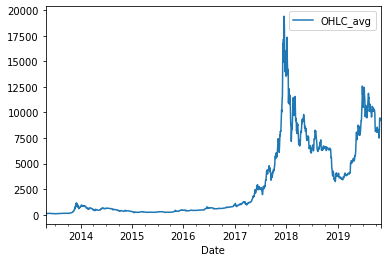

In [14]:
bitcoin_price.plot(x='Date', y="OHLC_avg")

In [15]:
data_length_in_days = (bitcoin_price.Date.values[-1] - bitcoin_price.Date.values[0]).astype('timedelta64[D]')
data_length_in_days

numpy.timedelta64(2380,'D')

In [16]:
split_point = bitcoin_price['Date'].values[0] + data_length_in_days * 0.8
split_point

numpy.datetime64('2018-07-15T00:00:00.000000000')

In [17]:
bitcoin_price_idx = bitcoin_price.set_index(["Date"], drop=True)
bitcoin_price_data = bitcoin_price_idx[['OHLC_avg']]
bitcoin_price_data_train = bitcoin_price_data[:split_point]
bitcoin_price_data_test = bitcoin_price_data[split_point:]
print(bitcoin_price_data_train.head())
print(bitcoin_price_data_test.head())

            OHLC_avg
Date                
2013-04-28  134.3975
2013-04-29  140.1175
2013-04-30  140.9950
2013-05-01  125.9000
2013-05-02  109.8675
             OHLC_avg
Date                 
2018-07-15  6323.0775
2018-07-16  6549.3800
2018-07-17  7033.0250
2018-07-18  7375.3900
2018-07-19  7408.7450


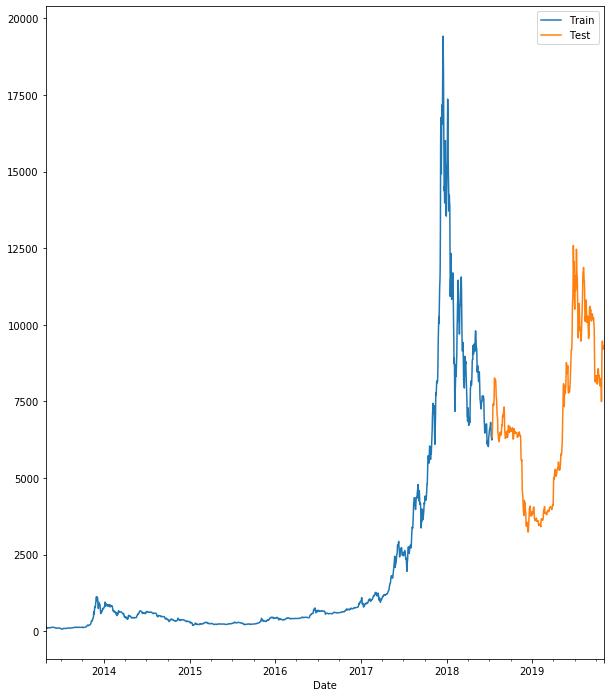

In [18]:
ax = bitcoin_price_data_train.plot(figsize=(10, 12))
bitcoin_price_data_test.plot(ax=ax)
plt.legend(['Train', 'Test'])
plt.show()

In [19]:
#Determine rolling statistics
rolmean = bitcoin_price_data.rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
rolstd = bitcoin_price_data.rolling(window=12).std()
print(rolmean,rolstd)

               OHLC_avg
Date                   
2013-04-28          NaN
2013-04-29          NaN
2013-04-30          NaN
2013-05-01          NaN
2013-05-02          NaN
...                 ...
2019-10-30  8546.981458
2019-10-31  8647.484583
2019-11-01  8739.393958
2019-11-02  8827.927917
2019-11-03  8919.354792

[2381 rows x 1 columns]               OHLC_avg
Date                  
2013-04-28         NaN
2013-04-29         NaN
2013-04-30         NaN
2013-05-01         NaN
2013-05-02         NaN
...                ...
2019-10-30  725.463348
2019-10-31  725.951069
2019-11-01  721.907466
2019-11-02  720.304287
2019-11-03  698.954374

[2381 rows x 1 columns]


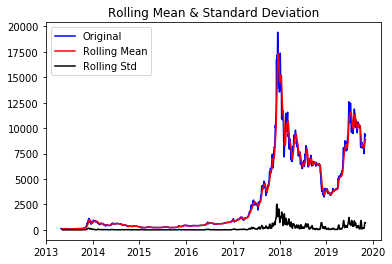

In [20]:
#Plot rolling statistics
original = plt.plot(bitcoin_price_data, color='blue', label='Original')
# A moving average is commonly used with time series data to smooth out short-term fluctuations and highlight longer-term trends or cycles.
roll_mean = plt.plot(rolmean, color='red', label='Rolling Mean')
# Moving Standard Deviation is a statistical measurement of market volatility. It makes no predictions of market direction, but it may serve as a confirming indicator. 
roll_standard = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [21]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf

In [22]:
def test_stationarity(timeseries):
    moving_avg = timeseries.rolling(window=12).mean()
    moving_std = timeseries.rolling(window=12).std()
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(moving_avg, color='red', label='Rolling Mean')
    std = plt.plot(moving_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    print('Results of Dicky Fuller Test:')
    dftest = adfuller(timeseries['OHLC_avg'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

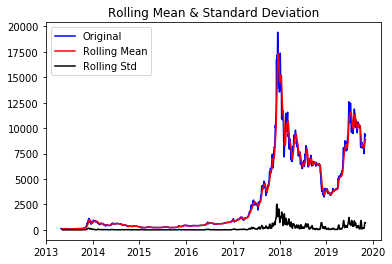

Results of Dicky Fuller Test:
Test Statistic                   -1.383836
p-value                           0.590000
#Lags Used                       27.000000
Number of Observations Used    2353.000000
Critical Value (1%)              -3.433132
Critical Value (5%)              -2.862769
Critical Value (10%)             -2.567424
dtype: float64


In [23]:
test_stationarity(bitcoin_price_data)

In [24]:
# https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

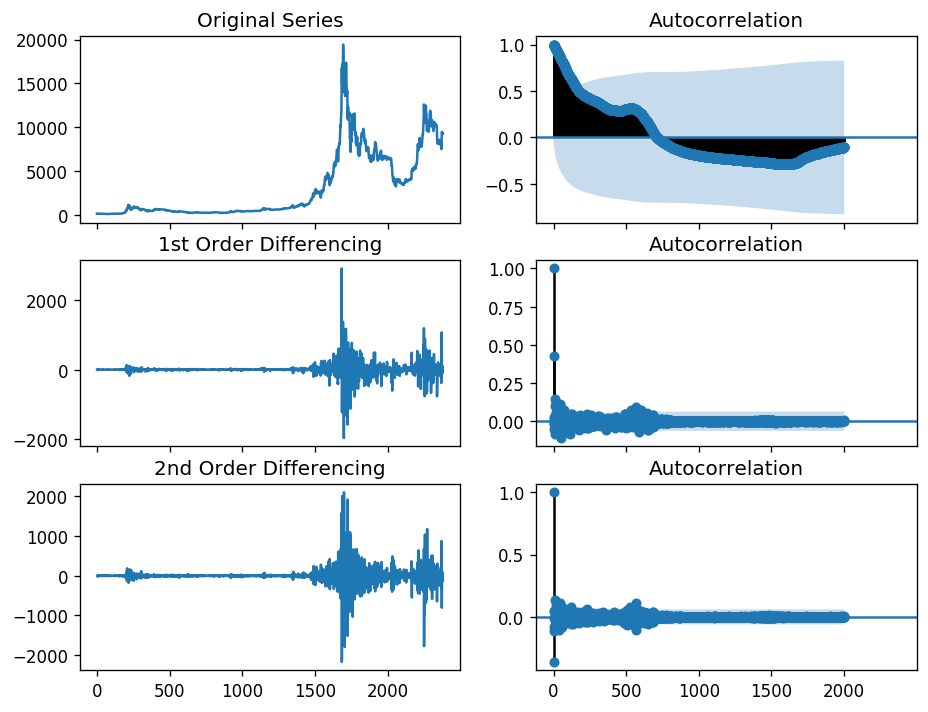

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9, 7), 'figure.dpi':120})

df = bitcoin_price["OHLC_avg"]
df.index = range(len(df.index))
# plot_acf(df, lags=2000)
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df)
axes[0, 0].set_title("Original Series")
plot_acf(df, lags=2000, ax=axes[0, 1])

axes[1, 0].plot(df.diff())
axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.diff().dropna(), lags=2000, ax=axes[1, 1])

axes[2, 0].plot(df.diff().diff())
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.diff().diff().dropna(), lags=2000, ax=axes[2, 1])

plt.show()


In [26]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

<Figure size 2220x1260 with 0 Axes>

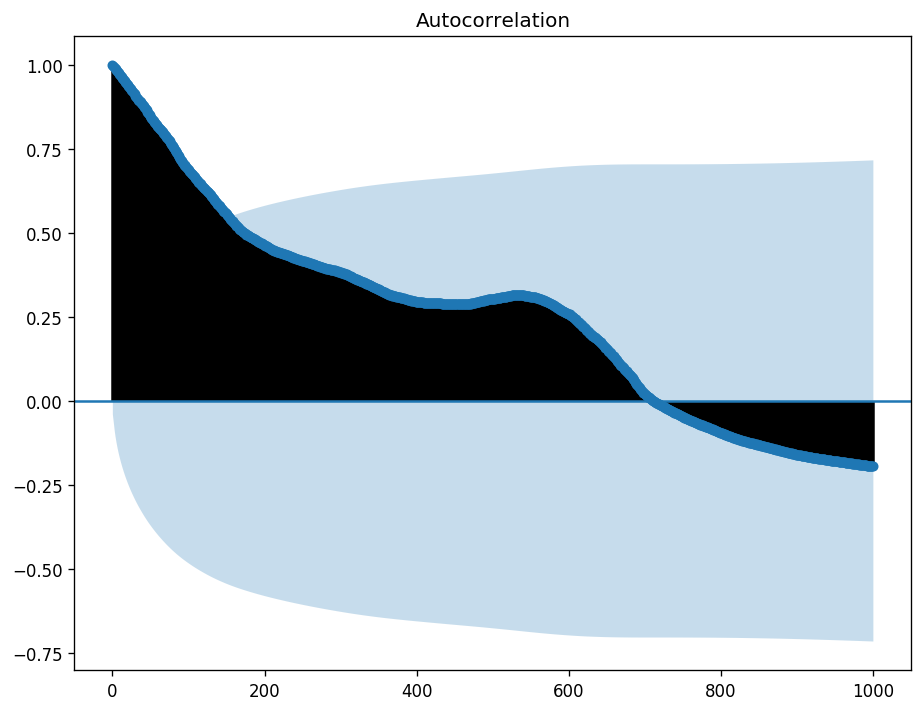

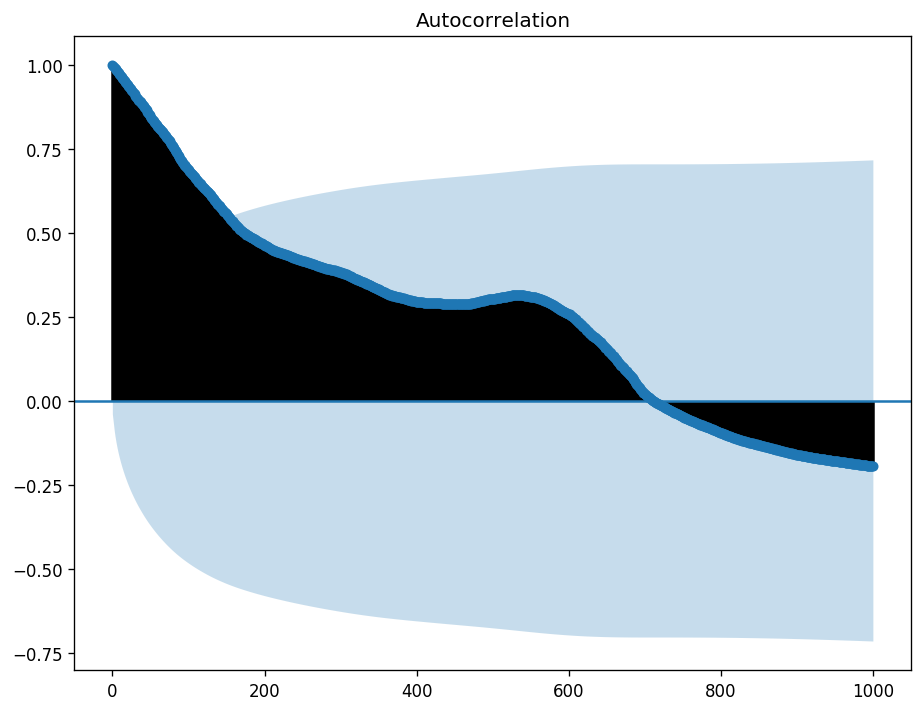

In [27]:
plot_acf(df.dropna(), lags=1000)

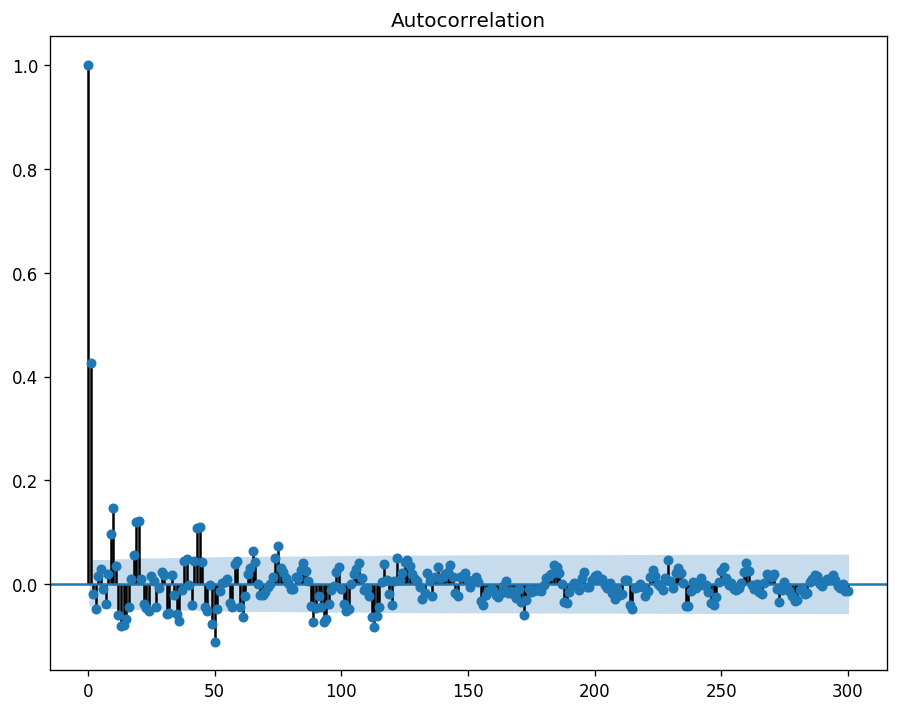

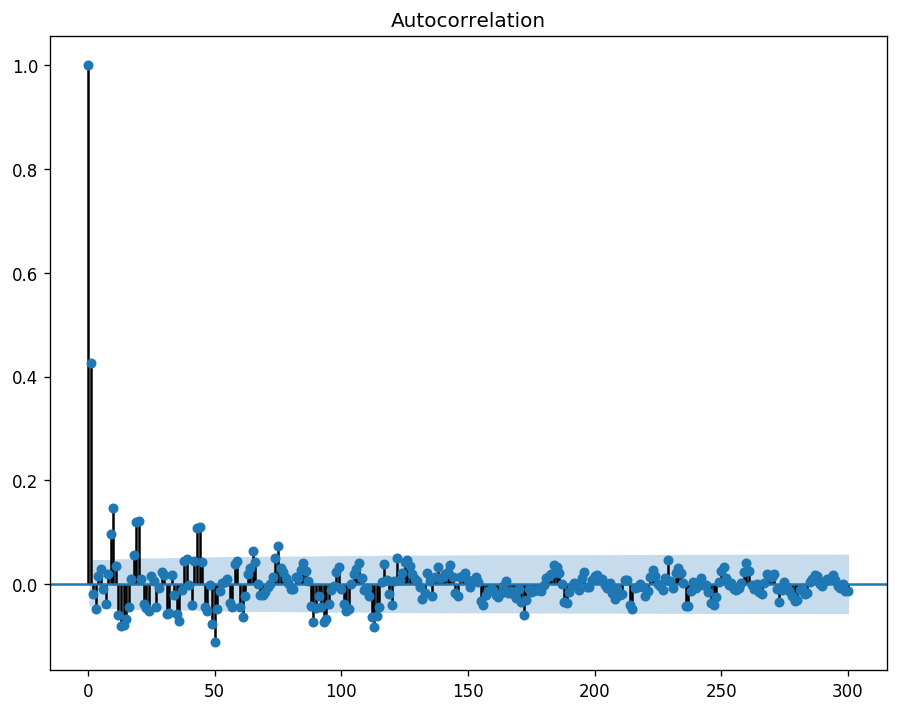

In [28]:
plot_acf(df.diff().dropna(), lags=300)

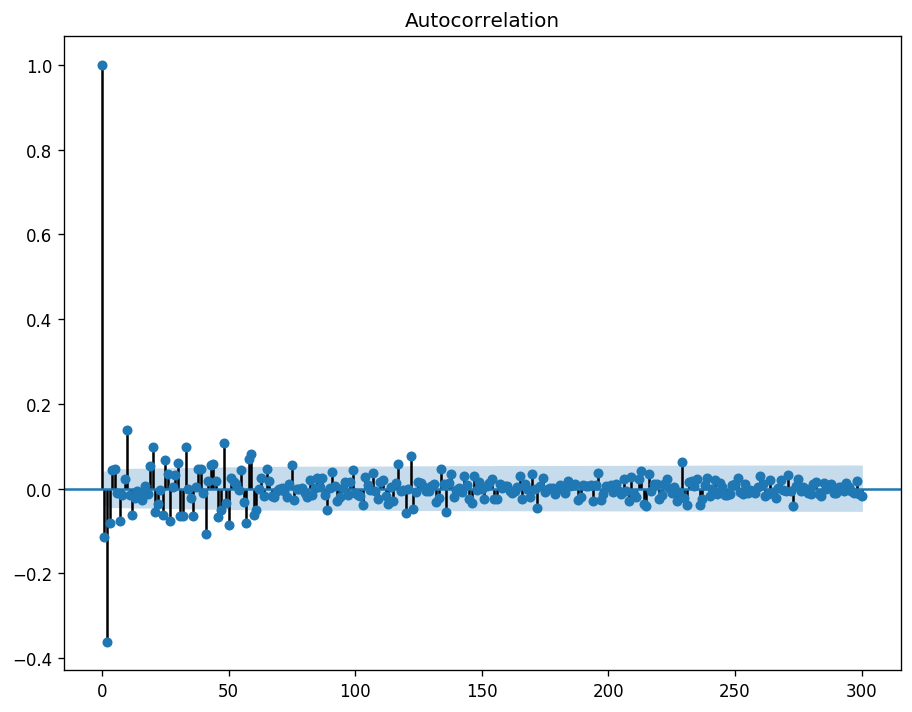

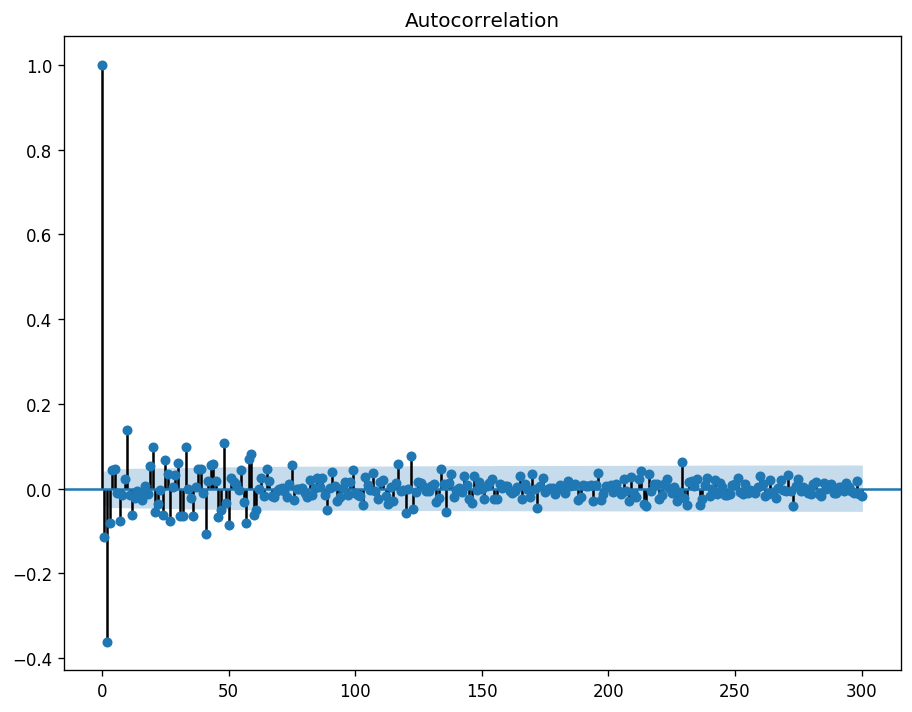

In [29]:
plot_acf(df.diff().diff().dropna(), lags=300)

In [30]:
# But on looking at the autocorrelation plot for the 2nd differencing the lag goes into the far negative zone fairly quick, which indicates, the series might have been over differenced.

In [31]:
from pmdarima.arima.utils import ndiffs
print(ndiffs(df, test='adf'))
print(ndiffs(df, test='kpss'))
print(ndiffs(df, test='pp'))

1
1
1


In [32]:
# You can observe that the PACF lag 1 is quite significant since is well above the significance line. Lag 2 turns out to be significant as well, slightly managing to cross the significance limit (blue region). But I am going to be conservative and tentatively fix the p as 1.

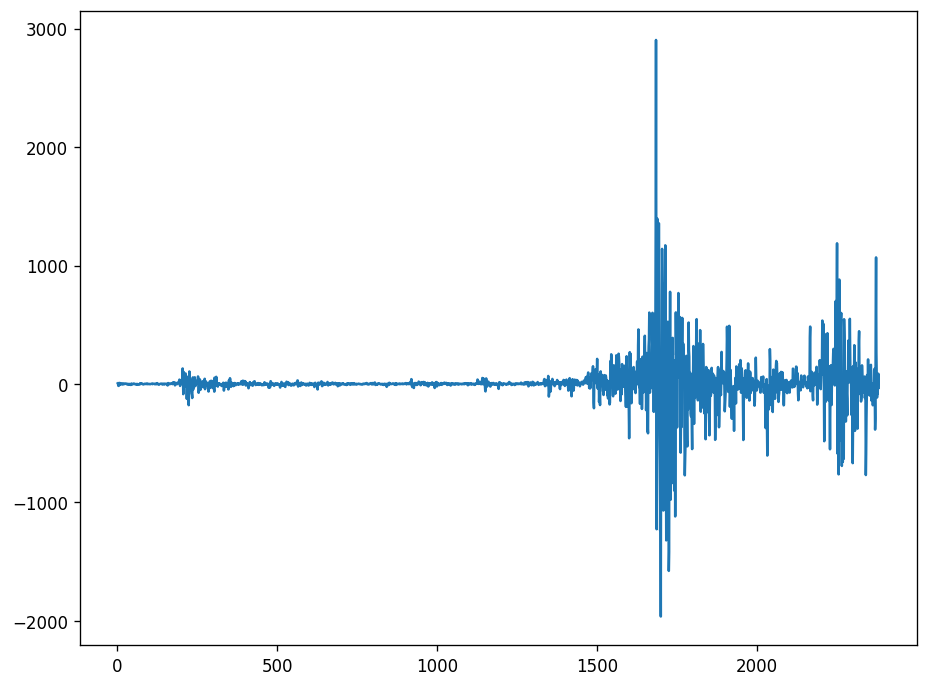

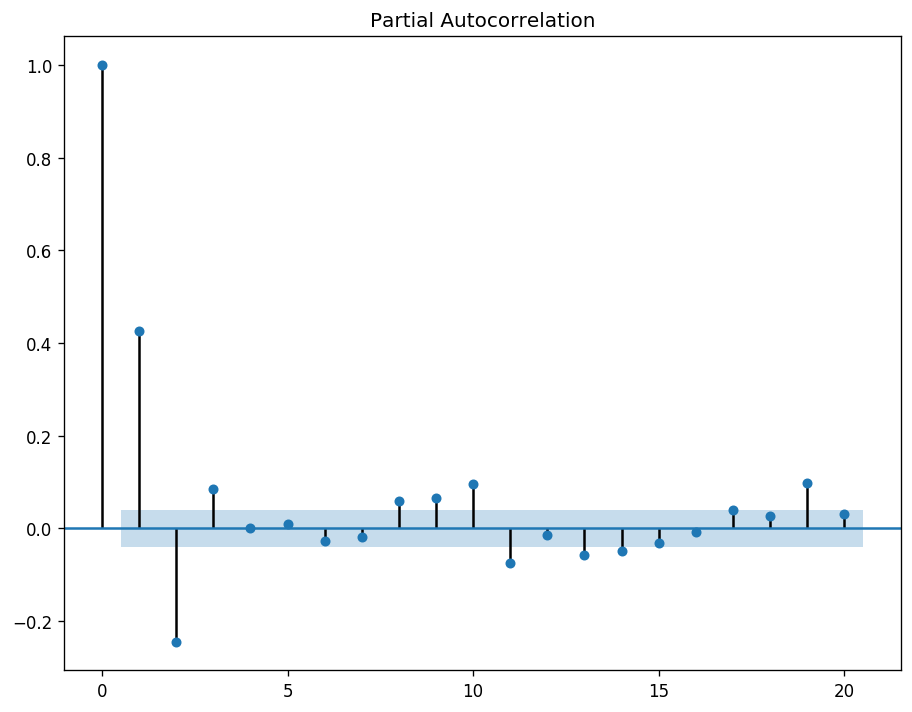

In [33]:
plt.plot(df.diff())
plot_pacf(df.diff().dropna(), lags=20)

plt.show()

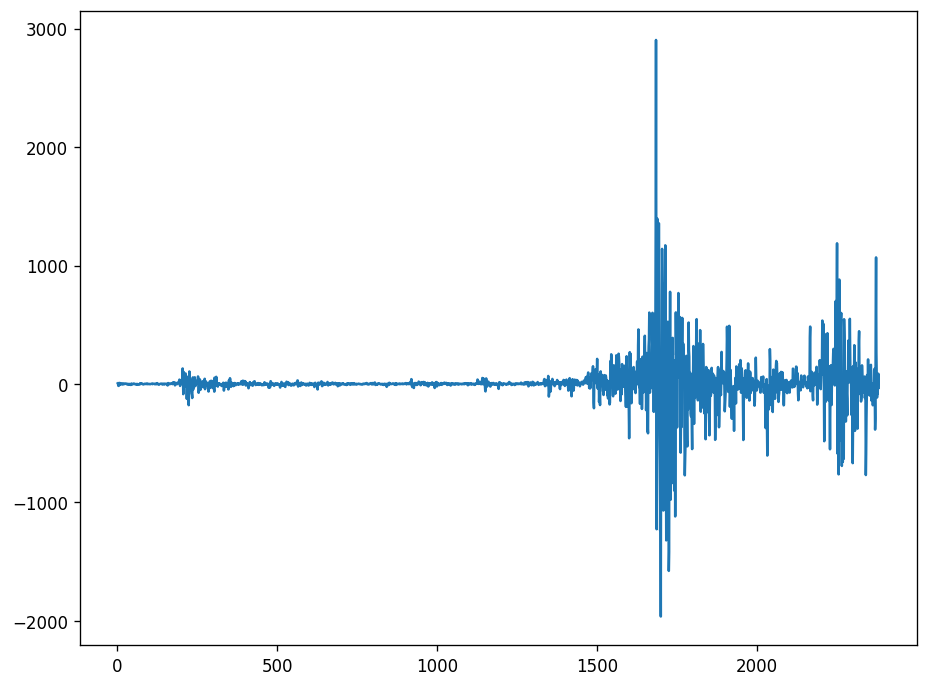

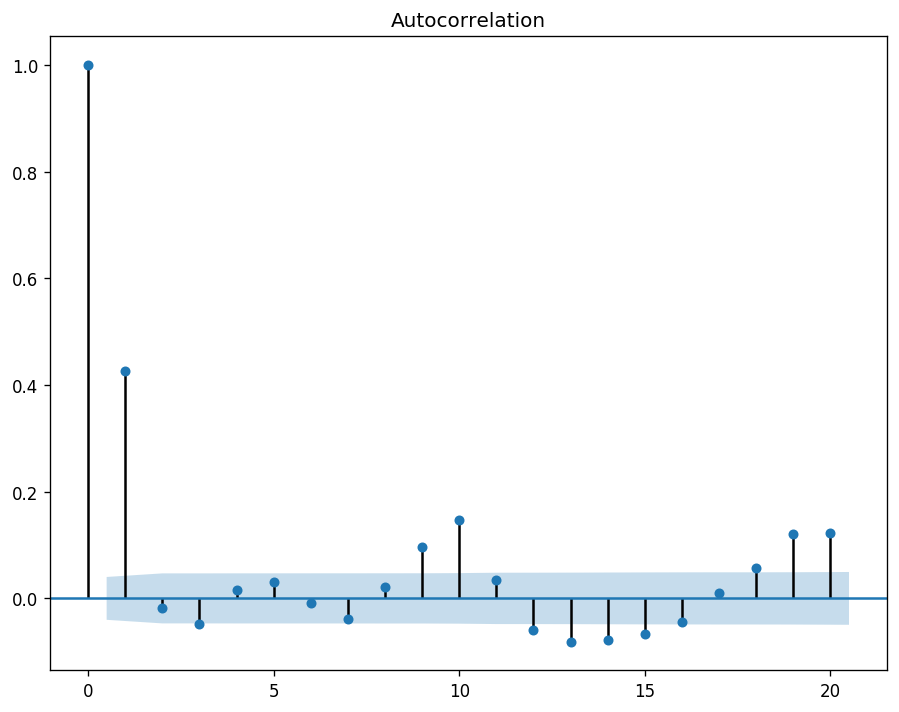

In [34]:
plt.plot(df.diff())
plot_acf(df.diff().dropna(), lags=20)

plt.show()

In [35]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(df, order=(1, 1, 1))
model_fit = model.fit(disp=0)
print(model_fit.summary())


                             ARIMA Model Results                              
Dep. Variable:             D.OHLC_avg   No. Observations:                 2380
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -15531.150
Method:                       css-mle   S.D. of innovations            165.122
Date:                Mon, 04 Nov 2019   AIC                          31070.300
Time:                        21:50:33   BIC                          31093.400
Sample:                             1   HQIC                         31078.708
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                3.8306      5.378      0.712      0.476      -6.711      14.372
ar.L1.D.OHLC_avg     0.0708      0.035      2.001      0.046       0.001       0.140
ma.L1.D.OHLC_avg     0.4767 

In [36]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(df, order=(2, 1, 1))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# The model AIC has reduced, which is good. The P Values of the AR1 and MA1 terms have improved and are highly significant (<< 0.05).

                             ARIMA Model Results                              
Dep. Variable:             D.OHLC_avg   No. Observations:                 2380
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -15526.194
Method:                       css-mle   S.D. of innovations            164.778
Date:                Mon, 04 Nov 2019   AIC                          31062.388
Time:                        21:50:33   BIC                          31091.262
Sample:                             1   HQIC                         31072.897
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                3.8226      5.009      0.763      0.445      -5.995      13.640
ar.L1.D.OHLC_avg     0.2500      0.070      3.572      0.000       0.113       0.387
ar.L2.D.OHLC_avg    -0.1262 

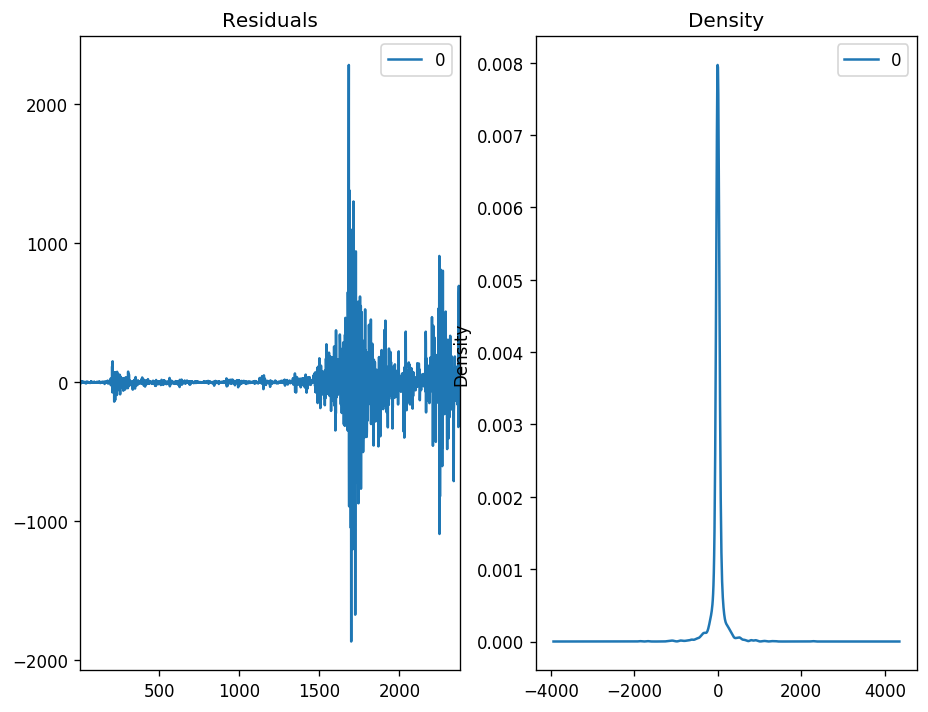

In [37]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

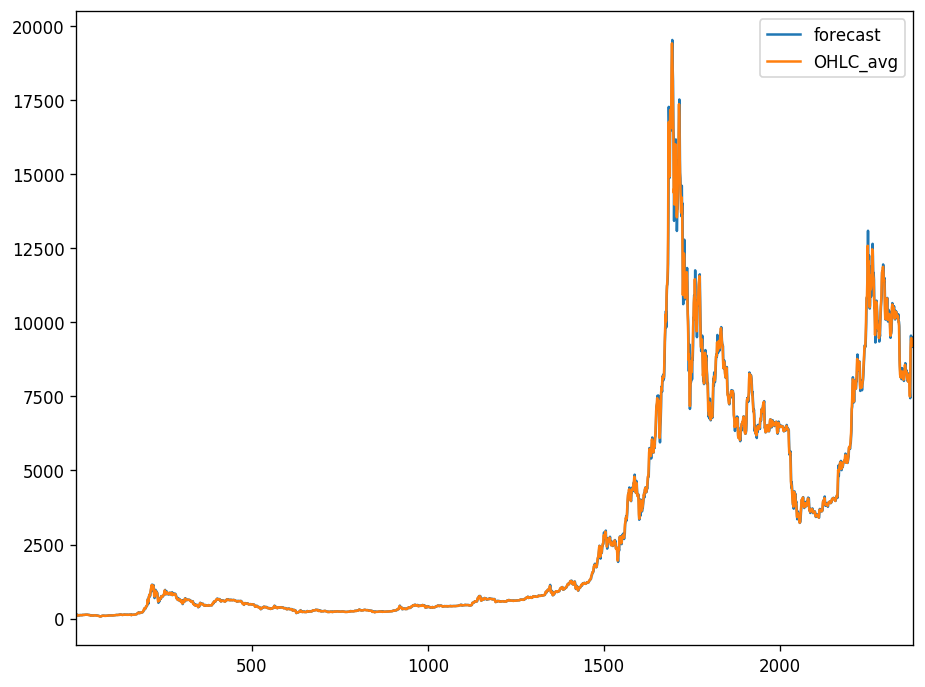

In [38]:
model_fit.plot_predict(dynamic=False)
plt.show()

R-Squared: 0.989887


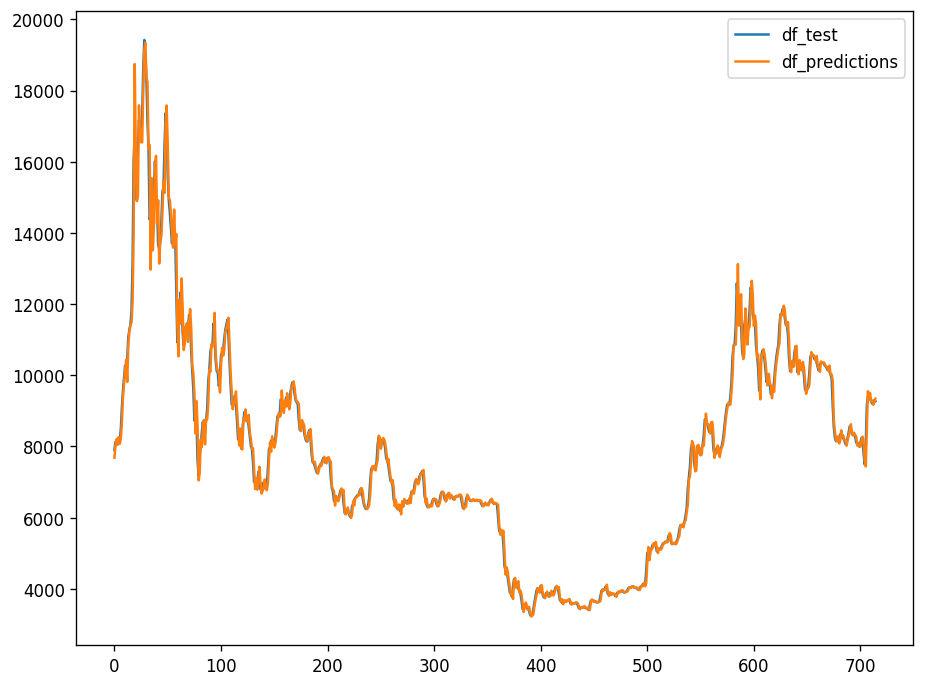

In [69]:
# using one step forward ARIMA to predict price 
# using r2_score to calculate r-squared
from sklearn.metrics import r2_score

df_split_point = int(len(df) * 0.7)
df_train, df_test = df[:df_split_point], df[df_split_point:]
history = [x for x in df_train]
predictions = []

for t in range(len(df_test)):
    model = ARIMA(history, order=(2, 1, 1))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    predictions.extend(yhat)
    history.append(df_test.iloc[t])

df_test = df_test.reset_index(drop=True)
df_predictions = pd.DataFrame(predictions)

plt.plot(df_test)
plt.plot(predictions)
plt.legend(['df_test', 'df_predictions'])
print('R-Squared: %f'%(r2_score(df_test, df_predictions)))


Fit ARIMA: order=(2, 2, 2) seasonal_order=(1, 0, 1, 12); AIC=17393.970, BIC=17437.306, Fit time=4.253 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 0, 0, 12); AIC=18046.032, BIC=18056.866, Fit time=0.050 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(1, 0, 0, 12); AIC=18026.050, BIC=18047.717, Fit time=0.921 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 0, 1, 12); AIC=17982.231, BIC=18003.899, Fit time=1.101 seconds
Fit ARIMA: order=(2, 2, 2) seasonal_order=(0, 0, 1, 12); AIC=17397.661, BIC=17435.580, Fit time=2.557 seconds
Fit ARIMA: order=(2, 2, 2) seasonal_order=(2, 0, 1, 12); AIC=17386.760, BIC=17435.513, Fit time=9.745 seconds
Fit ARIMA: order=(2, 2, 2) seasonal_order=(2, 0, 0, 12); AIC=17385.721, BIC=17429.057, Fit time=6.327 seconds
Fit ARIMA: order=(1, 2, 2) seasonal_order=(2, 0, 0, 12); AIC=17388.430, BIC=17426.349, Fit time=6.482 seconds


/opt/anaconda3/envs/forDA_kernel/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fit ARIMA: order=(3, 2, 2) seasonal_order=(2, 0, 0, 12); AIC=17388.290, BIC=17437.043, Fit time=12.063 seconds
Fit ARIMA: order=(2, 2, 1) seasonal_order=(2, 0, 0, 12); AIC=17434.644, BIC=17472.563, Fit time=7.451 seconds


/opt/anaconda3/envs/forDA_kernel/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 3) seasonal_order=(2, 0, 0, 12); AIC=17389.006, BIC=17437.759, Fit time=15.911 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(2, 0, 0, 12); AIC=17525.273, BIC=17557.775, Fit time=9.092 seconds


/opt/anaconda3/envs/forDA_kernel/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 3) seasonal_order=(2, 0, 0, 12); AIC=17390.144, BIC=17444.314, Fit time=20.672 seconds
Fit ARIMA: order=(2, 2, 2) seasonal_order=(1, 0, 0, 12); AIC=17395.966, BIC=17433.885, Fit time=2.699 seconds
Total fit time: 99.342 seconds


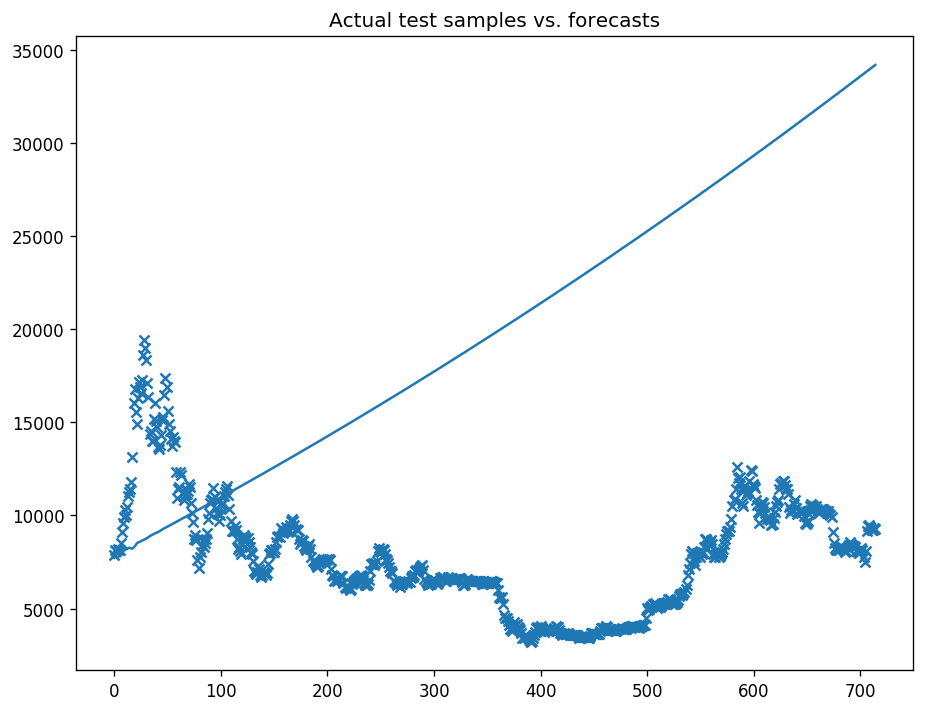

In [39]:
# second arima method: auto_arima
# https://www.alkaline-ml.com/pmdarima/auto_examples/example_simple_fit.html

import pmdarima as pm

df_split_point = int(len(df) * 0.7)
df_train, df_test = df[:df_split_point], df[df_split_point:]

arima = pm.auto_arima(df_train, error_action='ignore', trace=1, seasonal=True, m=12)

x = np.arange(df_test.shape[0])
plt.scatter(x, df_test, marker='x')
plt.plot(x, arima.predict(n_periods=df_test.shape[0]))
plt.title('Actual test samples vs. forecasts')
plt.show()


In [40]:
# logged data
# arima_data_logScale = np.log(bitcoin_price_data)
# test_stationarity(arima_data_logScale)

In [41]:
# 𝑙𝑜𝑔𝑠𝑐𝑎𝑙𝑒𝐿=𝑠𝑡𝑎𝑡𝑖𝑜𝑛𝑎𝑟𝑦𝑝𝑎𝑟𝑡(𝐿1)+𝑡𝑟𝑒𝑛𝑑(𝐿𝑇) 
# 𝑚𝑜𝑣𝑖𝑛𝑔𝑎𝑣𝑔𝑜𝑓𝑙𝑜𝑔𝑠𝑐𝑎𝑙𝑒𝐴=𝑠𝑡𝑎𝑡𝑖𝑜𝑛𝑎𝑟𝑦𝑝𝑎𝑟𝑡(𝐴1)+𝑡𝑟𝑒𝑛𝑑(𝐴𝑇) 
# 𝑟𝑒𝑠𝑢𝑙𝑡𝑠𝑒𝑟𝑖𝑒𝑠𝑅=𝐿−𝐴=(𝐿1+𝐿𝑇)−(𝐴1+𝐴𝑇)=(𝐿1−𝐴1)+(𝐿𝑇−𝐴𝑇)
# moving_avg = bitcoin_price_data.rolling(window=12).mean()
# arima_data_after_minus = arima_data_logScale - moving_avg
# arima_data_after_minus.dropna(inplace=True)
# arima_data_after_minus.head(12)
# test_stationarity(arima_data_after_minus)